In [187]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.models import ColumnDataSource
from bokeh.io import curdoc
from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models.ranges import FactorRange
from bokeh.palettes import Dark2_8  as palette

output_notebook()

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

Loading BokehJS ...

In [2]:
df = pd.read_csv("US_Accidents_March23.csv")
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


# 1. Motivation

# 2. Basic stats

In [3]:
print("The dataset consist of {} records with the following {} columns:".format(len(df), len(df.columns)), '\n')
for i in range(0, 47, 7):
    print(list(df.columns)[i:i+7])

The dataset consist of 7728394 records with the following 46 columns: 

['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng']
['End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County']
['State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)']
['Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)']
['Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit']
['Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In our analysis we decided to focus only on California state, which has the highest total number of accidents (2 times more than the second Florida state). In the following we're going to use only data related to California.

In [4]:
df_cal = df[df["State"] == "CA"].reset_index(drop=True)

In [5]:
# percentage of nan values
percentages = df_cal.isna().mean() * 100
percentages = percentages.sort_values(ascending=False)

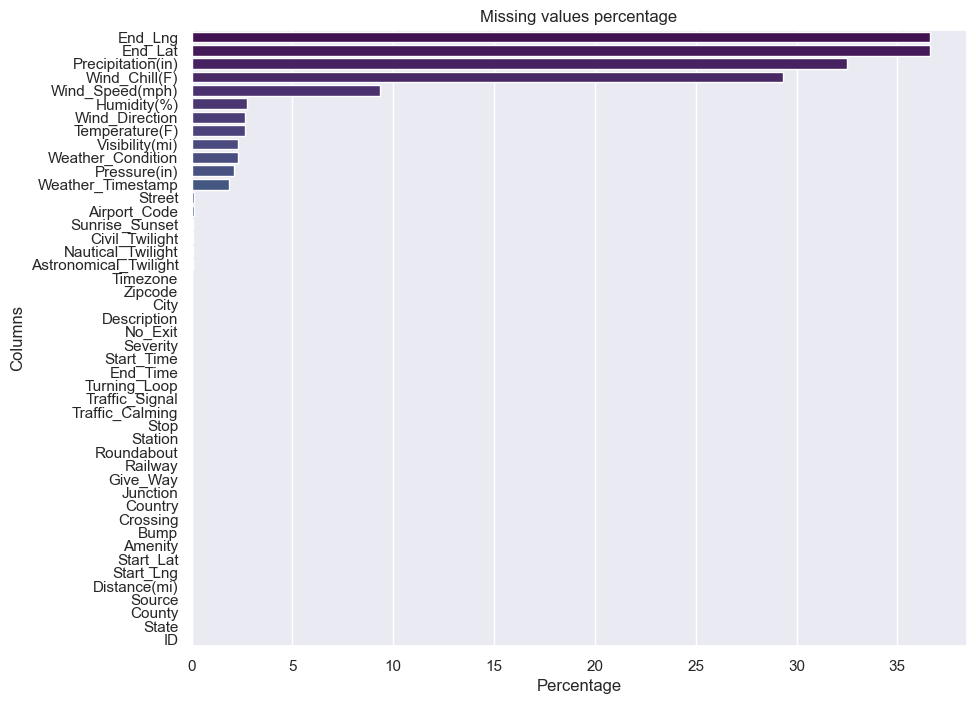

In [6]:
plt.figure(figsize=(10, 8))
sns.barplot(x=percentages.values, y=percentages.index, palette="viridis")
plt.title('Missing values percentage')
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.show()

We can see that there are only a few features where the problem of missing values is significant: **End_Lat** and **End_Lng** have over 35% of missing values - those columns are not vital for our analysis (we also have **Start_Lat** and **Start_Lng** columns that don't suffer from this problem), thus we can just discard them. Missing values ratios for **Precipitation(in)** and **Wind_Chill(F)** around 33% and 29%, respectively. Since the percentage of those missing values is rather high, we decided not to include them in our analysis. The rest of variables have less than 10% missing values, which can be easily solved by an appropriate missing values imputation, such as KNN imputation that would ensure the distributions of features would be sustained, or just by a simple mean or median for columns with small percentages of missing values. In order to keep our analysis simple, we chose mean for missing values imputation in continuous columns, and we removed rows with missing values in categorical columns. We also deleted **Description** column since it won't be usen in our analysis.

In [7]:
df_cal = df_cal.drop(["End_Lng", "End_Lat", "Precipitation(in)", "Wind_Chill(F)", "Description", "Source"], axis=1)

In [8]:
percentages

End_Lng                  36.598078
End_Lat                  36.598078
Precipitation(in)        32.513683
Wind_Chill(F)            29.341640
Wind_Speed(mph)           9.353848
Humidity(%)               2.775932
Wind_Direction            2.652356
Temperature(F)            2.639723
Visibility(mi)            2.304137
Weather_Condition         2.284211
Pressure(in)              2.131922
Weather_Timestamp         1.883793
Street                    0.140229
Airport_Code              0.121509
Sunrise_Sunset            0.077120
Civil_Twilight            0.077120
Nautical_Twilight         0.077120
Astronomical_Twilight     0.077120
Timezone                  0.034282
Zipcode                   0.034282
City                      0.000632
Description               0.000172
No_Exit                   0.000000
Severity                  0.000000
Start_Time                0.000000
End_Time                  0.000000
Turning_Loop              0.000000
Traffic_Signal            0.000000
Traffic_Calming     

In [9]:
df_cal.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-729,3,2016-06-21 10:34:40,2016-06-21 11:04:40,38.085300,-122.233017,0.0,Magazine St,Vallejo,Solano,CA,94591,US,US/Pacific,KAPC,2016-06-21 10:54:00,75.0,48.0,30.00,10.0,Variable,5.8,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,A-730,3,2016-06-21 10:30:16,2016-06-21 11:16:39,37.631813,-122.084167,0.0,I-880 N,Hayward,Alameda,CA,94544,US,US/Pacific,KHWD,2016-06-21 10:54:00,75.0,48.0,30.06,10.0,WSW,4.6,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,A-731,2,2016-06-21 10:49:14,2016-06-21 11:19:14,37.896564,-122.070717,0.0,I-680 N,Walnut Creek,Contra Costa,CA,94595,US,US/Pacific,KCCR,2016-06-21 10:53:00,82.9,31.0,29.97,10.0,NNW,4.6,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
3,A-732,3,2016-06-21 10:41:42,2016-06-21 11:11:42,37.334255,-122.032471,0.0,N De Anza Blvd,Cupertino,Santa Clara,CA,95014,US,US/Pacific,KNUQ,2016-06-21 10:56:00,75.9,48.0,30.04,10.0,NNE,4.6,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
4,A-733,2,2016-06-21 10:16:26,2016-06-21 11:04:16,37.250729,-121.910713,0.0,Norman Y Mineta Hwy,San Jose,Santa Clara,CA,95118,US,US/Pacific,KRHV,2016-06-21 09:50:00,75.2,41.0,30.06,10.0,Variable,5.8,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [10]:
missing_values_cols = ["Wind_Speed(mph)", "Humidity(%)", "Temperature(F)", "Visibility(mi)", "Pressure(in)"]
for col in missing_values_cols:
    df_cal[[col]] = df_cal[[col]].fillna(df_cal[col].mean())

In [11]:
df_cal = df_cal.dropna().reset_index(drop=True)

In order to ensure proper analysis with time variables, we transformed appropriate columns to datetimes, as well as added columns with year, hour, and day of week. We also dropped data from year 2023 since we don't have full data from that year, and year 2016, since we noticed that we have significantly less data from this year, which might be due to low data quality at the beginning.

In [12]:
# transform data type 
df_cal['Start_Time'] = pd.to_datetime(df_cal['Start_Time'])
df_cal['End_Time'] = pd.to_datetime(df_cal['End_Time'])

#extract information from columns
df_cal['Year'] = df_cal['Start_Time'].dt.year
df_cal['Hour'] = df_cal['Start_Time'].dt.hour
df_cal['DayOfWeek'] = df_cal['Start_Time'].dt.dayofweek

# Drop year 2023 
df_cal = df_cal[(df_cal['Year'] != 2016) & (df_cal['Year'] != 2023)]

In [13]:
df_cal.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Hour,DayOfWeek
8405,A-9207,3,2017-01-01 00:17:36,2017-01-01 00:47:12,37.925392,-122.320595,0.01,I-80 E,El Cerrito,Contra Costa,CA,94530,US,US/Pacific,KCCR,2017-01-01 00:53:00,44.1,79.0,29.91,10.0,WSW,5.8,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night,2017,0,6
8406,A-9208,3,2017-01-01 00:26:08,2017-01-01 01:16:06,37.878185,-122.307175,0.01,I-580 W,Berkeley,Alameda,CA,94710,US,US/Pacific,KOAK,2017-01-01 00:53:00,51.1,83.0,29.97,10.0,West,11.5,Overcast,False,False,True,False,False,False,False,False,False,True,False,False,False,Night,Night,Night,Night,2017,0,6
8407,A-9209,2,2017-01-01 00:53:41,2017-01-01 01:22:35,38.014820,-121.640579,0.00,Taylor Ln,Oakley,Contra Costa,CA,94561,US,US/Pacific,KCCR,2017-01-01 00:53:00,44.1,79.0,29.91,10.0,WSW,5.8,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2017,0,6
8408,A-9210,3,2017-01-01 01:18:51,2017-01-01 01:48:01,37.912056,-122.323982,0.01,Bayview Ave,Richmond,Contra Costa,CA,94804,US,US/Pacific,KCCR,2017-01-01 01:11:00,44.1,82.0,29.95,9.0,SW,3.5,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2017,1,6
8409,A-9211,3,2017-01-01 01:20:12,2017-01-01 01:49:47,37.925392,-122.320595,0.01,I-80 E,El Cerrito,Contra Costa,CA,94530,US,US/Pacific,KCCR,2017-01-01 01:11:00,44.1,82.0,29.95,9.0,SW,3.5,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night,2017,1,6


In [14]:
df_cal.to_csv("data_california.csv", index=False)

In [15]:
df_temp = pd.read_csv("data_california.csv")
df_temp.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Hour,DayOfWeek
0,A-9207,3,2017-01-01 00:17:36,2017-01-01 00:47:12,37.925392,-122.320595,0.01,I-80 E,El Cerrito,Contra Costa,CA,94530,US,US/Pacific,KCCR,2017-01-01 00:53:00,44.1,79.0,29.91,10.0,WSW,5.8,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night,2017,0,6
1,A-9208,3,2017-01-01 00:26:08,2017-01-01 01:16:06,37.878185,-122.307175,0.01,I-580 W,Berkeley,Alameda,CA,94710,US,US/Pacific,KOAK,2017-01-01 00:53:00,51.1,83.0,29.97,10.0,West,11.5,Overcast,False,False,True,False,False,False,False,False,False,True,False,False,False,Night,Night,Night,Night,2017,0,6
2,A-9209,2,2017-01-01 00:53:41,2017-01-01 01:22:35,38.014820,-121.640579,0.00,Taylor Ln,Oakley,Contra Costa,CA,94561,US,US/Pacific,KCCR,2017-01-01 00:53:00,44.1,79.0,29.91,10.0,WSW,5.8,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2017,0,6
3,A-9210,3,2017-01-01 01:18:51,2017-01-01 01:48:01,37.912056,-122.323982,0.01,Bayview Ave,Richmond,Contra Costa,CA,94804,US,US/Pacific,KCCR,2017-01-01 01:11:00,44.1,82.0,29.95,9.0,SW,3.5,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2017,1,6
4,A-9211,3,2017-01-01 01:20:12,2017-01-01 01:49:47,37.925392,-122.320595,0.01,I-80 E,El Cerrito,Contra Costa,CA,94530,US,US/Pacific,KCCR,2017-01-01 01:11:00,44.1,82.0,29.95,9.0,SW,3.5,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night,2017,1,6


We can divide our columns into 3 general categories: location of the accident, weather and traffic conditions. We're going to inspect each of them separately.

### Basic stats: Location

We have 9 columns related to location: 4 categorical ones (**City**, **County**, **State**, **Zipcode**) and 3 continuous (**Start_Lat**, **Start_Lng**, **Distance(mi)**).

In [34]:
location_cat = ['City', 'County', 'State', 'Zipcode']

for col in location_cat:
    print(col)
    print('Number of unique values:', df_cal[col].nunique(), '\n')

City
Number of unique values: 1143 

County
Number of unique values: 58 

State
Number of unique values: 1 

Zipcode
Number of unique values: 117070 



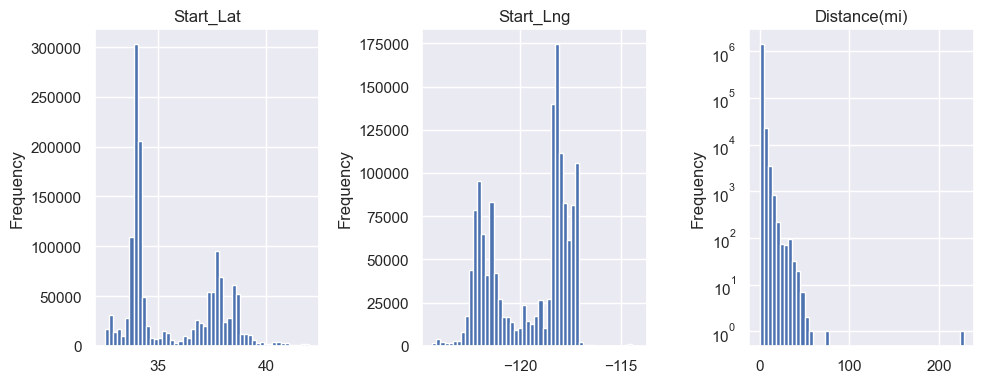

In [35]:
location_cont = ['Start_Lat', 'Start_Lng', 'Distance(mi)']

num_rows = 1
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4))  # Adjust figsize as needed

for i, col in enumerate(location_cont):
    row_index = i // num_cols  # Calculate the row index
    col_index = i % num_cols  # Calculate the column index
    ax = axes[col_index]  # Access the axis
    df_cal[col].plot(kind='hist', ax=ax, bins=50)
    if col == 'Distance(mi)':
        ax.set_yscale('log')  # Set logarithmic scale for 'Distance(mi)' column
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')    

# Adjust layout
plt.tight_layout()
plt.show()


The plot above shows histogram of each of continuous location columns. We can see that both **Start_Lat** and **Start_Lng** has bimodal distributions, **Distance(mi)** seems to follow power-law distribution.

### Basic stats: Weather

There are 9 columns that seem relevant in our analysis. 2 categorical: **Weather_Condition**, **Wind_Direction**, and 5 continuous: **Temperature(F)**, **Humidity(%)**, **Pressure(in)**, **Visibility(mi)**, **Wind_Speed(mph)**.

In [36]:
weather_cat = ['Weather_Condition', 'Wind_Direction']

for col in weather_cat:
    print(col)
    print('Number of unique values:', df_cal[col].nunique(), '\n')

Weather_Condition
Number of unique values: 82 

Wind_Direction
Number of unique values: 24 



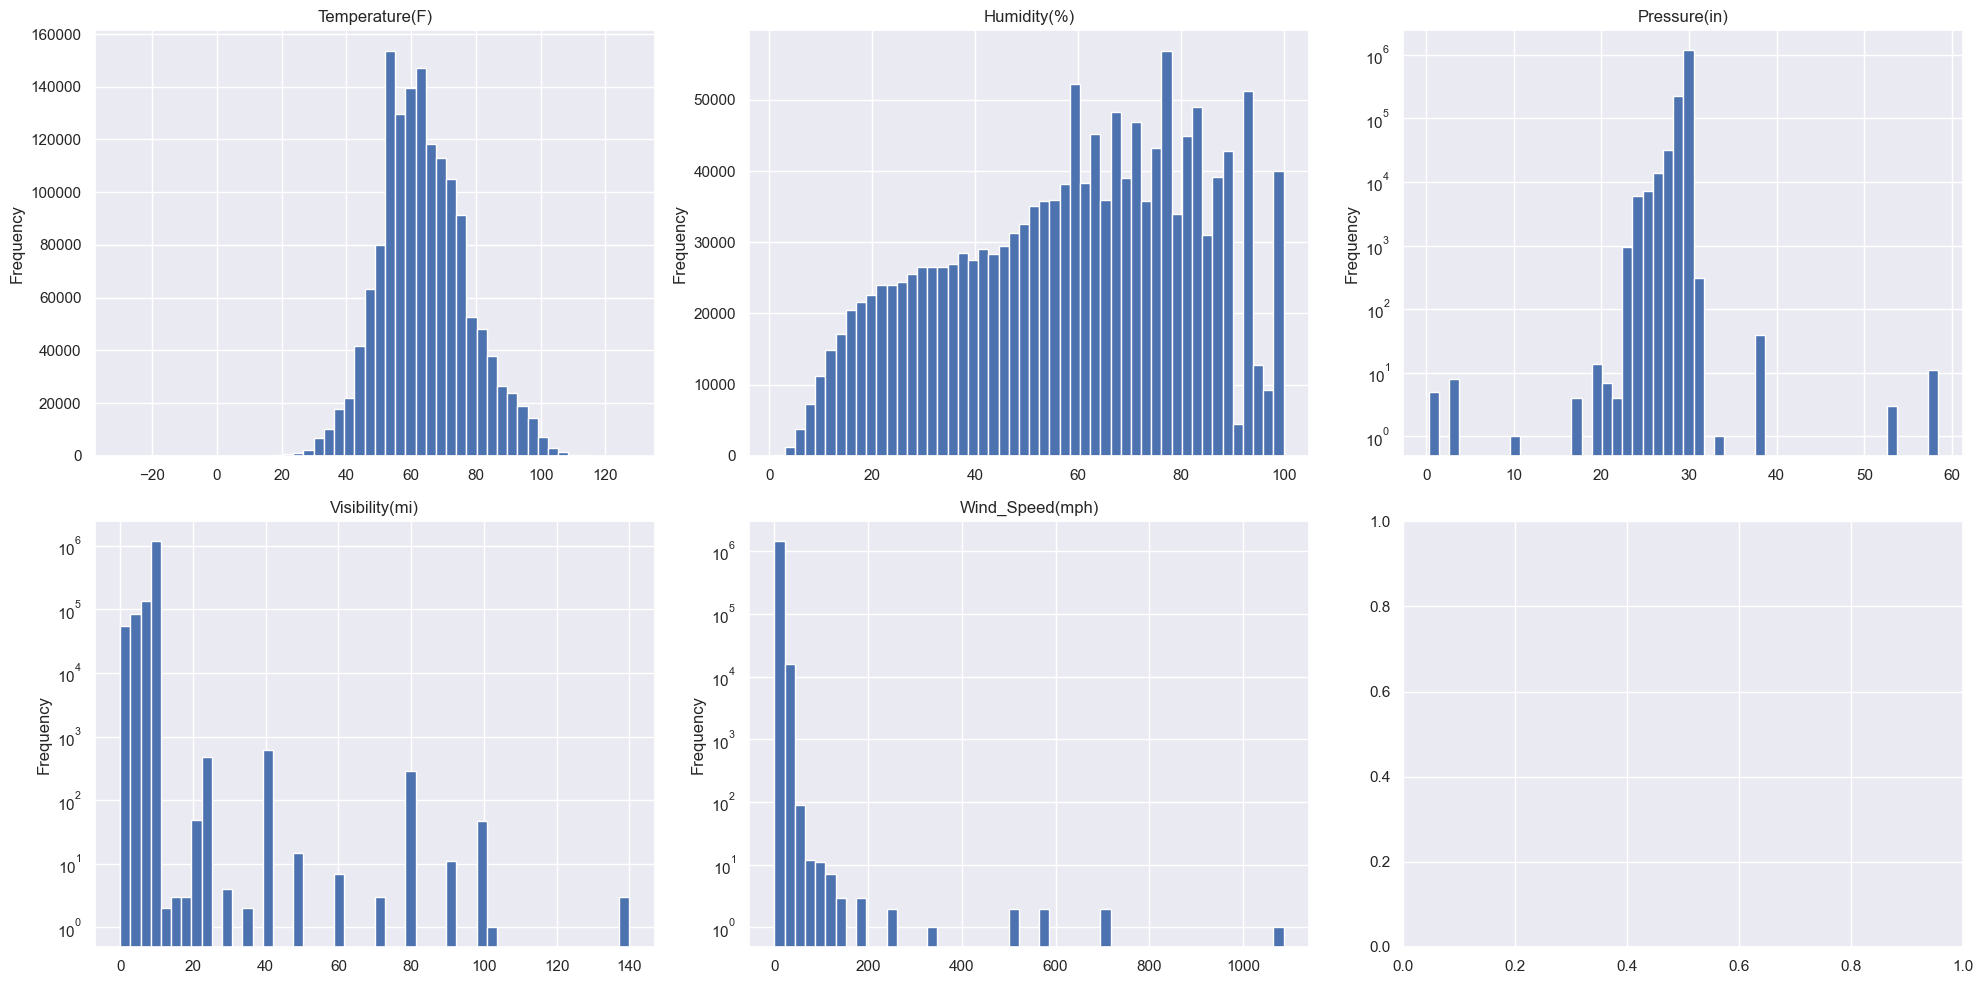

In [37]:
weather_cont = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust figsize as needed

for i, col in enumerate(weather_cont):
    row_index = i // num_cols  # Calculate the row index
    col_index = i % num_cols  # Calculate the column index
    ax = axes[row_index, col_index]  # Access the axis
    df_cal[col].plot(kind='hist', ax=ax, bins=50)
    if col in ['Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']:
        ax.set_yscale('log')  # Set logarithmic scale for 'Distance(mi)' column
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')    

# Adjust layout
plt.tight_layout()
plt.show()


In the plot above we can see that **Temperature(F)** and **Pressure(in)** have approximately Gaussian distributions.

## 3.Traffic

For traffic category we only have 13 categorical columns that specify if there's a specific object/place in the neighbourhood of the accident, e.g. roundabout, station, or crossing.

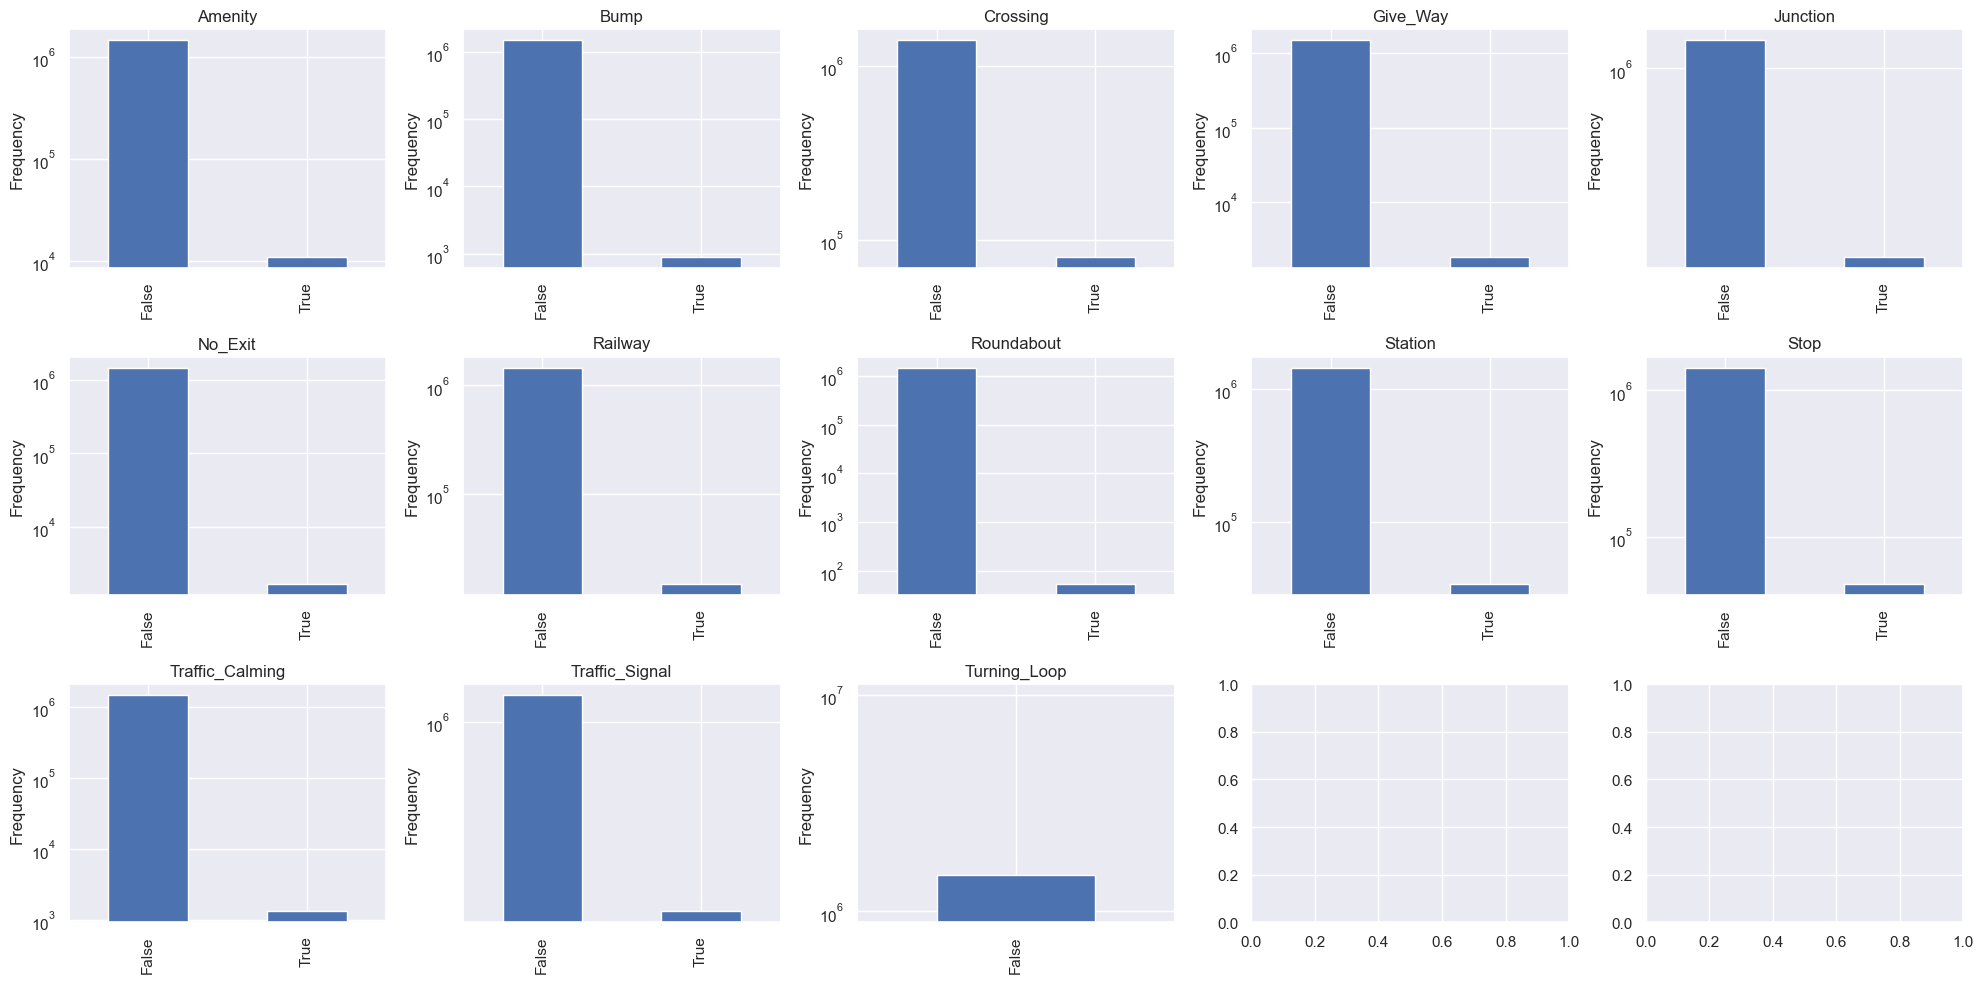

In [38]:
traffic_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way','Junction', 
                'No_Exit', 'Railway', 'Roundabout','Station', 'Stop', 
                'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

num_rows = 3
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust figsize as needed

for i, col in enumerate(traffic_cols):
    row_index = i // num_cols  # Calculate the row index
    col_index = i % num_cols  # Calculate the column index
    ax = axes[row_index, col_index]  # Access the axis
    df_cal[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_yscale('log')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')    

# Adjust layout
plt.tight_layout()
plt.show()

For all traffic variables, majority of records is equal to false (apart from turning loop, which didn't appear even once in the dataset, thus we can discard this column). Below we can see percentages of True and False values for each column. We can see that **junction** and **traffic signal** are most common, appearing in respectively around 11% and 8% of all records.

In [39]:
for i, col in enumerate(traffic_cols):
    print(df_cal[col].value_counts(normalize=True), '\n')

False    0.992603
True     0.007397
Name: Amenity, dtype: float64 

False    0.999391
True     0.000609
Name: Bump, dtype: float64 

False    0.946083
True     0.053917
Name: Crossing, dtype: float64 

False    0.998744
True     0.001256
Name: Give_Way, dtype: float64 

False    0.894276
True     0.105724
Name: Junction, dtype: float64 

False    0.998878
True     0.001122
Name: No_Exit, dtype: float64 

False    0.990165
True     0.009835
Name: Railway, dtype: float64 

False    0.999964
True     0.000036
Name: Roundabout, dtype: float64 

False    0.976825
True     0.023175
Name: Station, dtype: float64 

False    0.967735
True     0.032265
Name: Stop, dtype: float64 

False    0.999116
True     0.000884
Name: Traffic_Calming, dtype: float64 

False    0.923281
True     0.076719
Name: Traffic_Signal, dtype: float64 

False    1.0
Name: Turning_Loop, dtype: float64 



### Basic stats: Severity of accidents

Apart from 3 categories described above, we also have data about severity of accident (understood as how severe was the impact of accident on traffic), with 1 being the least severe accident and 4 the most severe. Below we can see the distribution of severity variable across our dataset.

In [31]:
def plot_severity(data, state=None):
    if state:
        data = data[data['State'] == state]
    plt.hist(data['Severity'], bins=[0.5, 1.5, 2.5, 3.5, 4.5], width=0.7)
    plt.yscale('log')
    plt.xlabel('Severity')
    plt.ylabel('Accident count')
    plt.title('Severity of accidents histogram')
    plt.xticks(range(1, 5))
    plt.show();

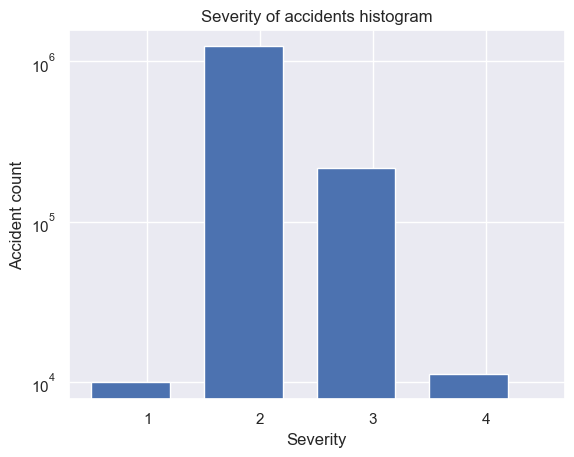

In [40]:
plot_severity(df_cal)

In [41]:
df_cal["Severity"].value_counts(normalize=True)

2    0.840559
3    0.145186
4    0.007561
1    0.006694
Name: Severity, dtype: float64

We can see that majority (84%) of accidents have severity equal to 2, 15% of accidents have severity equal to 3, and less than 1% have the highest possible severity or were the least severe.

Below we can see how the situation looked like in separate states:

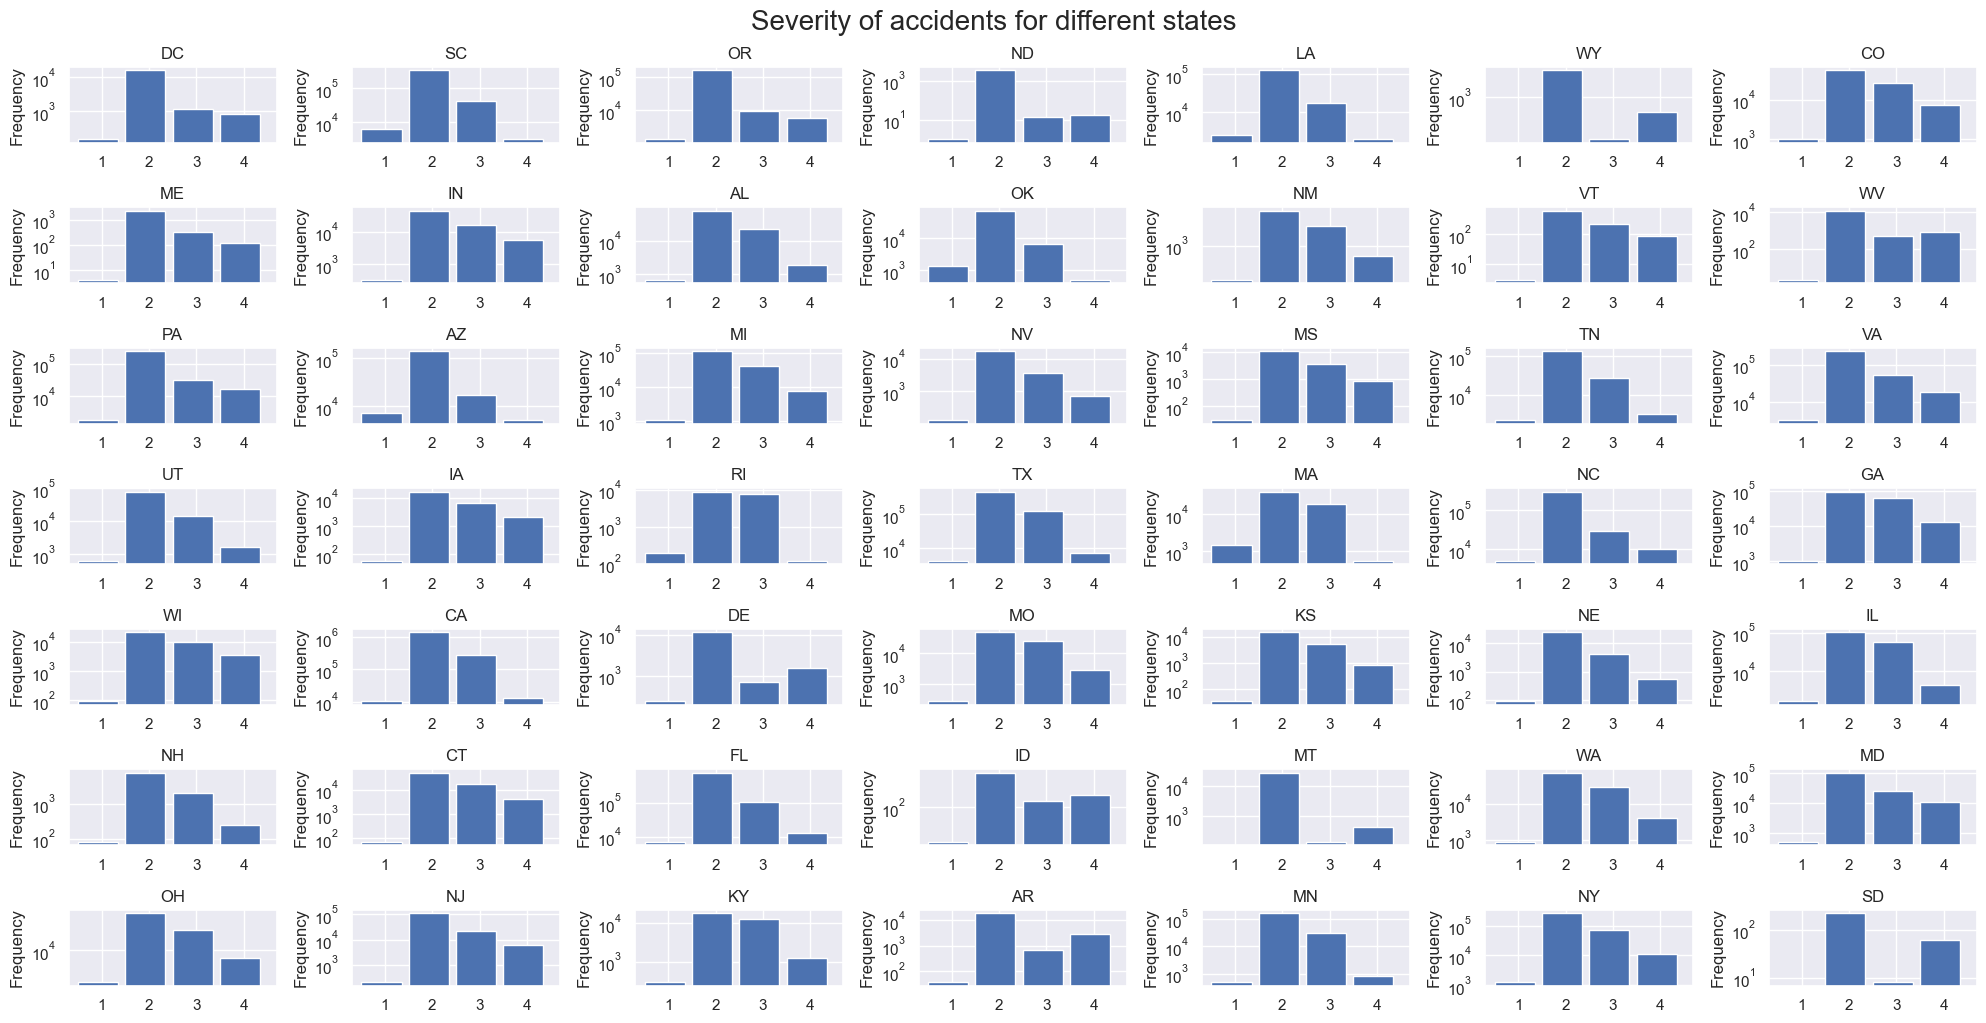

In [42]:
states = set(df['State'].values)

num_rows = 7
num_cols = 7
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust figsize as needed

for i, state in enumerate(states):
    row_index = i // num_cols  # Calculate the row index
    col_index = i % num_cols  # Calculate the column index
    ax = axes[row_index, col_index]  # Access the axis
    df[df['State'] == state]['Severity'].plot(kind='hist', ax=ax, bins=[0.5, 1.5, 2.5, 3.5, 4.5], width=0.85)
    ax.set_xticks(range(1, 5))
    ax.set_yscale('log')
    ax.set_title(state)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')    

# Adjust layout
plt.tight_layout(pad=1.)  # Increase pad value to add space between subplots
plt.suptitle('Severity of accidents for different states', y=1.02, fontsize=20)  # Adjust y value for the suptitle position
plt.show()

We can see that now the situation is quite different: severity equal to 2 still has the highest occurence in all of the states, but there are states like Rhode Island or Kentucky where there's almost the same percentage of accident with severity 2 and 3. There are also states, like Montana, South Dakota or West Virginia, where there are more accidents of severity 4 that severity 3.

# 3. Data analysis

In [15]:
df_cal = pd.read_csv("data_california.csv")

df_cal['Start_Time'] = pd.to_datetime(df_cal['Start_Time'])
df_cal['End_Time'] = pd.to_datetime(df_cal['End_Time'])

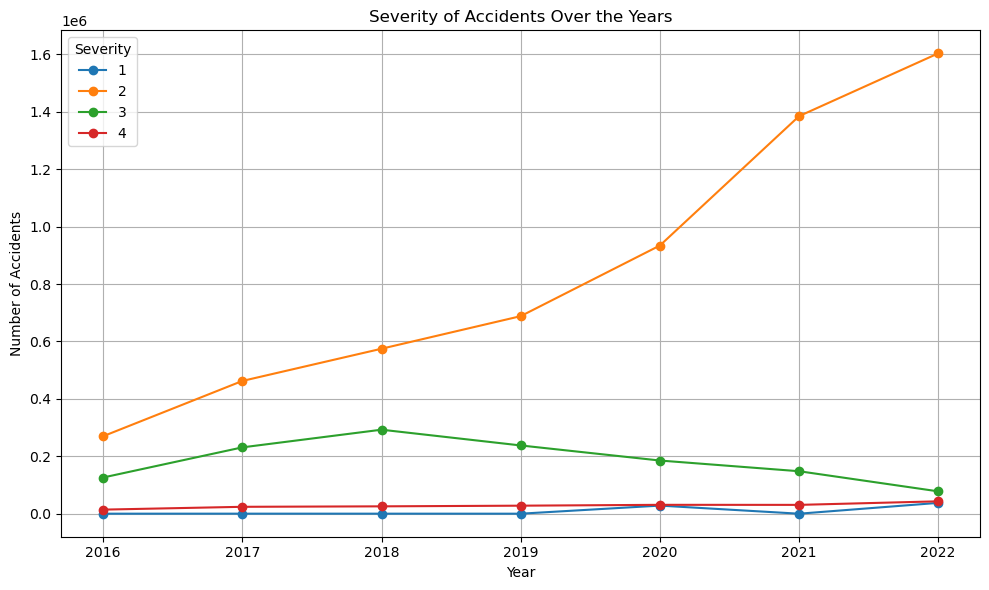

In [14]:
# Group data by year and severity, and count the number of accidents
severity_counts = df.groupby(['Year', 'Severity']).size().unstack(fill_value=0)

# Plot the severity of accidents over the years
severity_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Severity of Accidents Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

In the plot above we can see how the severity of accidents changed over the years. Number of the most and the least severe accidents was quite stable during the years. Accidents with severity 3 had a peak in 2018, but since then the number of accidents was slowly decreasing throughout the years. What's interesting is that the number of accidents with severity 2 (and a total number of accidents as well) has been sharply increasing every single year.

## Distribution of number of accidents

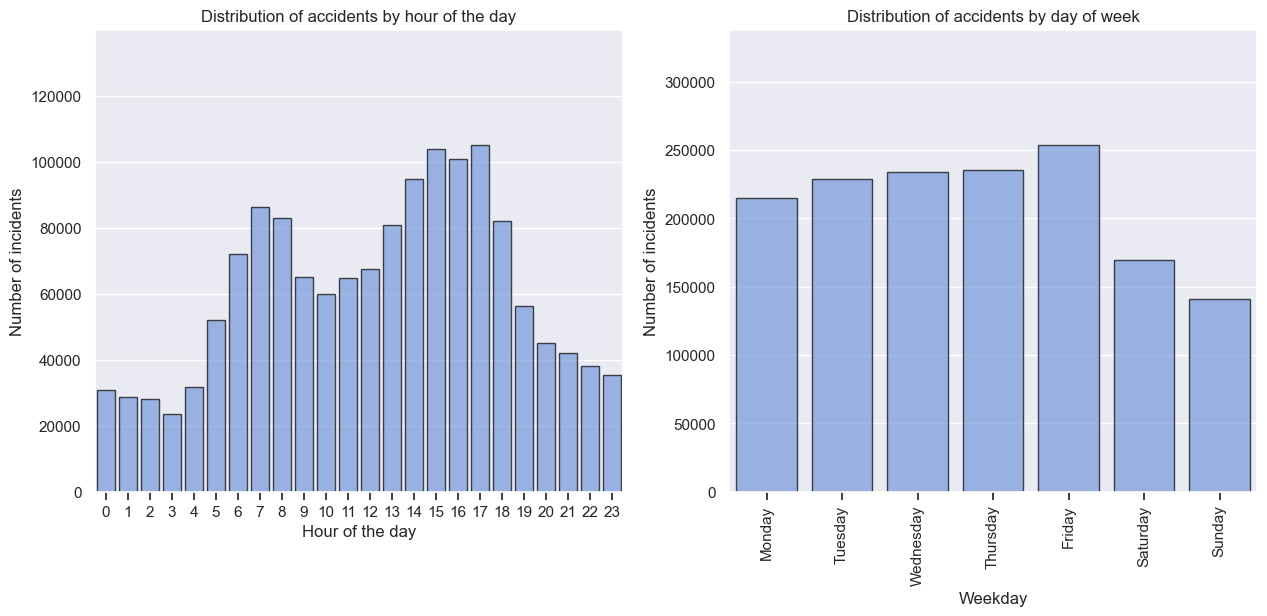

In [199]:
hourly_counts = df_cal['Hour'].value_counts().sort_index()
fig = plt.figure(figsize=(15,6))

# Plot the hourly counts
ax = fig.add_subplot(1, 2, 1)
g = sns.barplot(x=hourly_counts.index, y=hourly_counts.values, ax=ax, edgecolor="black", color="cornflowerblue", alpha=0.7)
ax.set_xlabel("Hour of the day")
ax.set_ylim(top=hourly_counts.values.max() + hourly_counts.values.max()/3)
ax.set_ylabel('Number of incidents')
ax.set_title("Distribution of accidents by hour of the day")
ax.tick_params(bottom=True)

df_cal['DayOfWeekName'] = df_cal['Start_Time'].dt.day_name()
weekday_counts = df_cal['DayOfWeekName'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot weekday counts
ax = fig.add_subplot(1, 2, 2)
g = sns.barplot(x=weekday_counts.index, y=weekday_counts.values, edgecolor="black", color="cornflowerblue", alpha=0.7)
ax.set_xlabel("Weekday")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
ax.set_ylim(top=weekday_counts.values.max() + weekday_counts.values.max()/3)
ax.set_ylabel('Number of incidents')
ax.tick_params(bottom=True)
ax.set_title("Distribution of accidents by day of week")
plt.show()

In [188]:
grouped_data = df_cal.groupby(["Hour", "DayOfWeekName"])['ID'].count().reset_index(name="Count")
grouped_data.head()

,Hour,DayOfWeekName,Count
0,0,Friday,4510
1,0,Monday,4101
2,0,Saturday,4960
3,0,Sunday,5004
4,0,Thursday,4198


In [189]:
day_count = df_cal.groupby(["DayOfWeekName"])['ID'].count().reset_index(name="Count")
day_count.head()

,DayOfWeekName,Count
0,Friday,253535
1,Monday,215195
2,Saturday,169641
3,Sunday,141050
4,Thursday,235447


In [190]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for d in days:
    grouped_data.loc[grouped_data["DayOfWeekName"] == d, "Count"] /= day_count.loc[day_count["DayOfWeekName"] == d]["Count"].values[0]

In [191]:
grouped_pivot = grouped_data.pivot(columns="DayOfWeekName", index="Hour", values="Count")

In [192]:
source = ColumnDataSource(grouped_pivot)

In [193]:
hours = list(range(1, 25))
hours = [str(h) for h in hours]
p = figure(x_range=FactorRange(factors=hours), max_width=1000, height=500, sizing_mode="stretch_width",
           title="Distribution of traffic accidents throughout hours of the day")

In [194]:
colors = itertools.cycle(palette) 

bar = {}
for indx, i in enumerate(days):
    bar[i] = p.vbar(x="Hour", top=i, source=grouped_pivot, legend_label=i,  muted_alpha=0.3, muted=True, color=next(colors))
    bar[i].visible = True if indx == 0 else False

In [195]:
p.legend.click_policy="hide"
p.add_layout(p.legend[0], 'right')
show(p)

In [196]:
output_file("weekdays_bokeh.html")
save(p)

'D:\\Dokumenty\\DTU\\02806 Social Data Analysis and Visualization\\social_data_final_project\\final_notebook\\weekdays_bokeh.html'

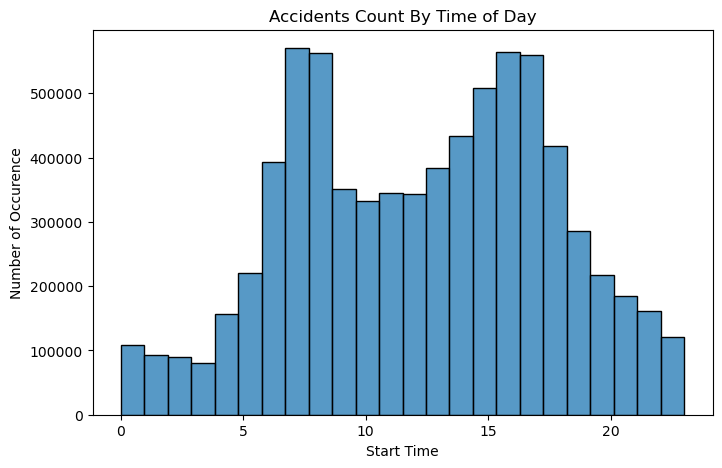

In [15]:
us_accidents = df.astype({'Start_Time': 'datetime64[ns]', 'End_Time': 'datetime64[ns]'})

sns.histplot(us_accidents['Start_Time'].dt.hour, bins = 24)

plt.xlabel("Start Time")
plt.ylabel("Number of incidents")
plt.title('Accidents Count By Time of Day')

plt.show()

In the ploat above we can see the distribution of number of accidents over the hours of the day. As one could expect, we can observe two peaks: around 9 a.m. and 5 p.m. These are peak hours - people are usually travelling to/from work then, so the probability of an accident in these hours is definitely higher. There is much smaller number of accidents during the night - which is also understandable because there's much less traffic during the night.

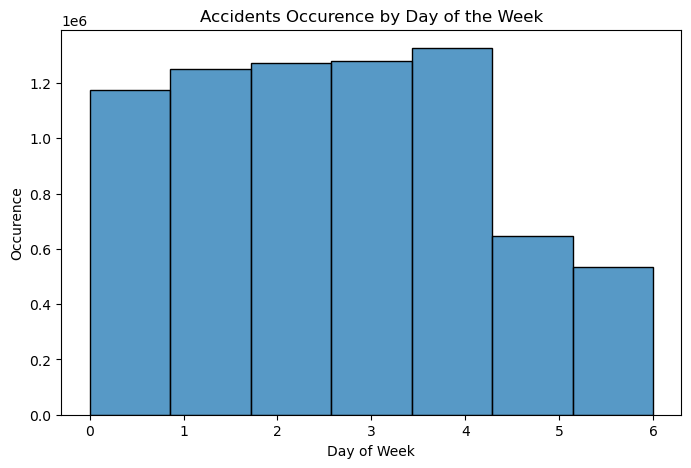

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(us_accidents['Start_Time'].dt.dayofweek, bins = 7)

plt.xlabel("Day of Week")
plt.ylabel("Occurence")
plt.title('Accidents Occurence by Day of the Week')

plt.show()

We can also see how does the distribution of number of accidents looks like during the week - and this one is also quite intuitive. Most accidents happen during weekdays, with the largest number of accidents on Friday. There's much less accidents on weekends with the smallest number on Sunday. 

In [17]:
saturday = us_accidents[us_accidents['Start_Time'].dt.dayofweek == 5]
sunday = us_accidents[us_accidents['Start_Time'].dt.dayofweek == 6]

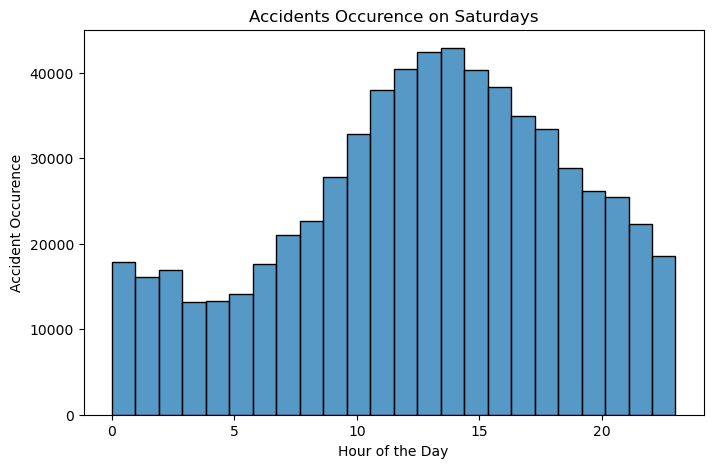

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(saturday['Start_Time'].dt.hour, bins = 24)

plt.xlabel("Hour of the Day")
plt.ylabel("Accident Occurence")
plt.title('Accidents Occurence on Saturdays')

plt.show()

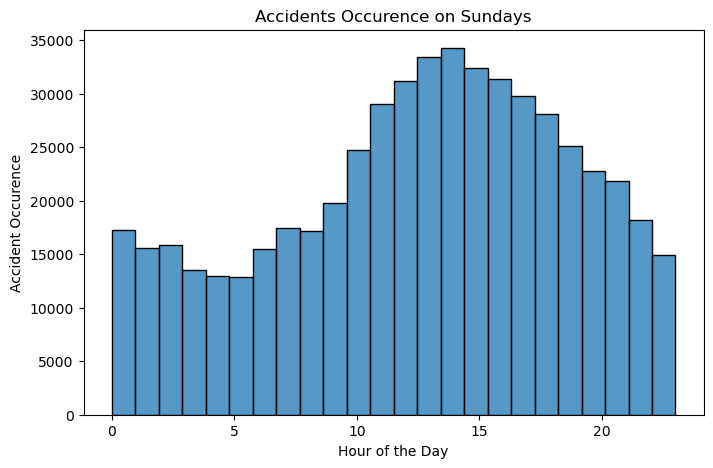

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(sunday['Start_Time'].dt.hour, bins = 24)

plt.xlabel("Hour of the Day")
plt.ylabel("Accident Occurence")
plt.title('Accidents Occurence on Sundays')

plt.show()

We saw before the distribution of number of accidents over the hours. We also decided to inspect how it looks like specifically for Saturdays and Sundays. We can see that the situation is quite different - most accidents happen in the middle of the day, around 15, and the least accidents happen around 5 in the morning.

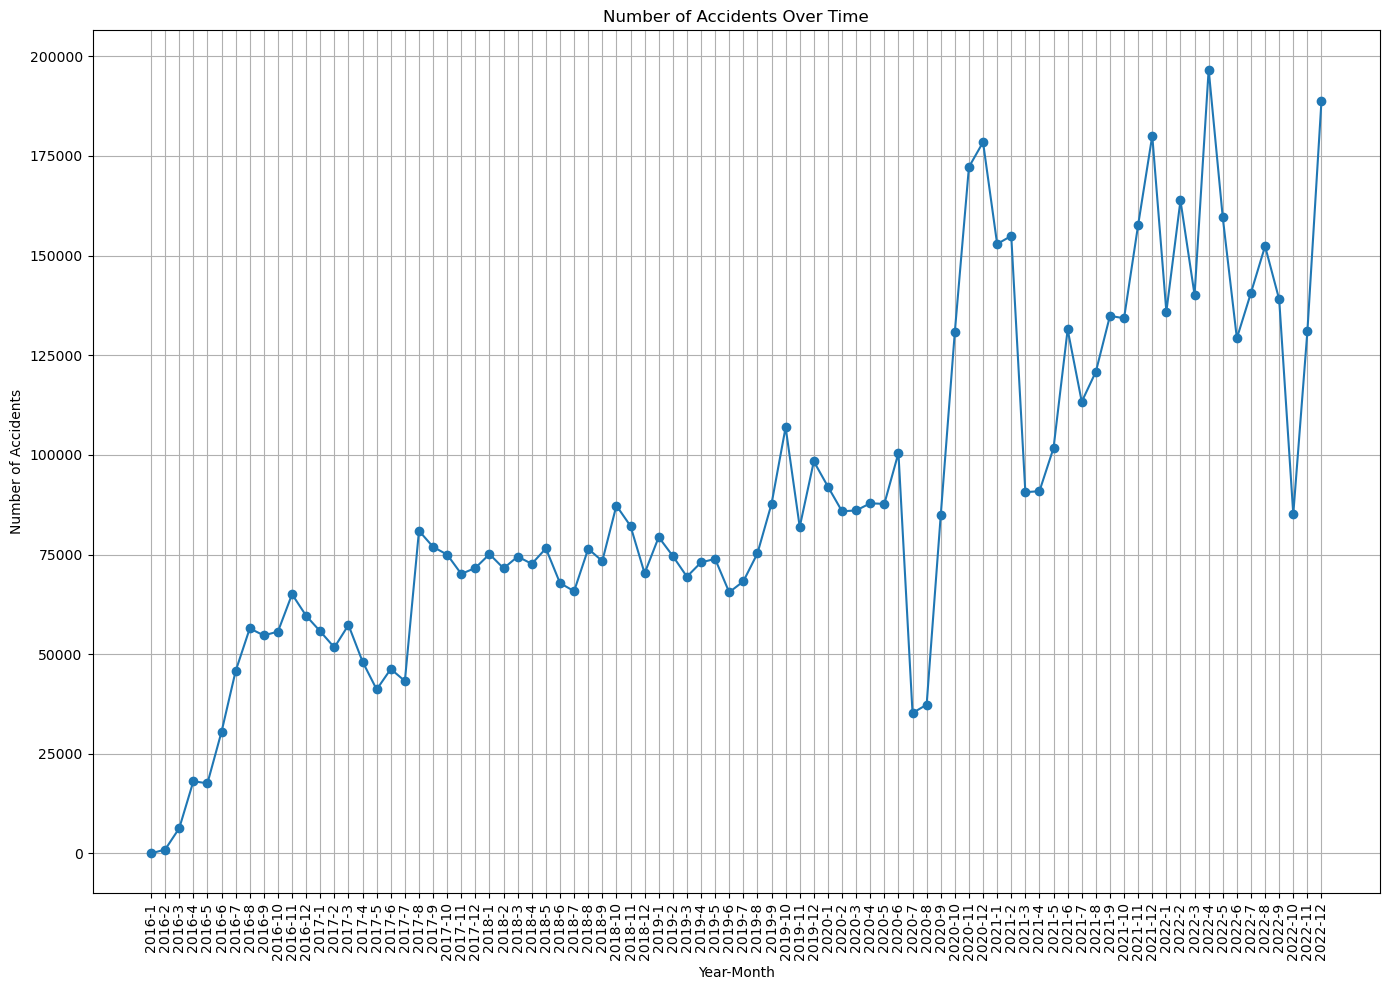

In [21]:
# Extract year and month from 'Start_Time'
us_accidents['Year'] = us_accidents['Start_Time'].dt.year
us_accidents['Month'] = us_accidents['Start_Time'].dt.month

# Group by year and month, and count the number of accidents
accidents_per_month = us_accidents.groupby(['Year', 'Month']).size().reset_index(name='Accident_Count')

# Plotting
plt.figure(figsize=(14, 10))
plt.plot(accidents_per_month['Year'].astype(str) + '-' + accidents_per_month['Month'].astype(str), accidents_per_month['Accident_Count'], marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents Over Time')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


Above we can see how the number of accidents changed over the months. There's a general positive trend, but we can also see some interesting patterns. Most years we can see some drops around summer time, and there's one huge drop in July and August 2020. It's probably caused not only by holiday, but also the fact that there was a global pandemic and people were travelling much less. There's also a huge peak right after summer 2020. We can see that we have almost no accidents at the beginning of 2016, which might cause some doubts about quality of the data and poses a question if we should use a whole dataset in our analysis.

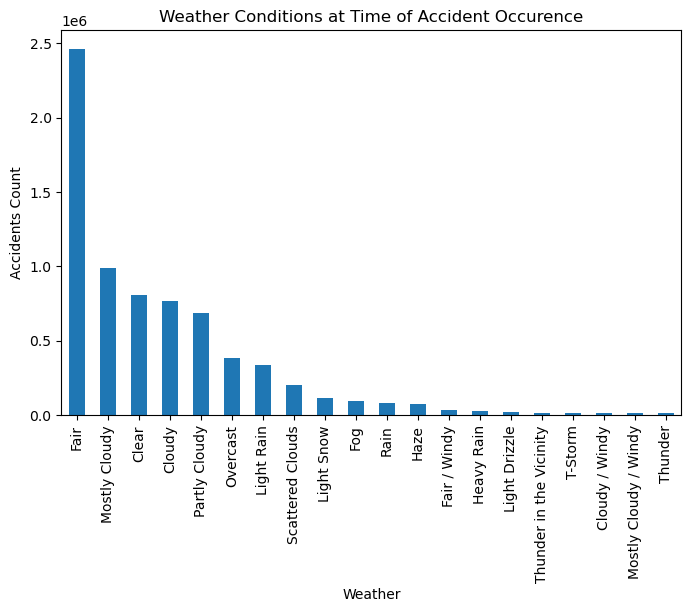

In [22]:
weather_conditions = df.groupby(['Weather_Condition']).count()['ID']

fig, ax = plt.subplots(figsize=(8,5))
weather_conditions.sort_values(ascending=False)[:20].plot(kind='bar')
ax.set(title = 'Weather Conditions at Time of Accident Occurence',
       xlabel = 'Weather',
       ylabel = 'Accidents Count')
plt.show()

In the plot above we can see the distribution of accidents during specific weather conditions. It's interesting that, contrary to what one may suspect, most accidents happend during fair weather conditions, and much less of them happen during e.g. rain or snow. At the same time we have to remember that when the conditions are difficult less people might decide to drive a car, so the number of accidents is indeed smaller - but the severity might be higher.

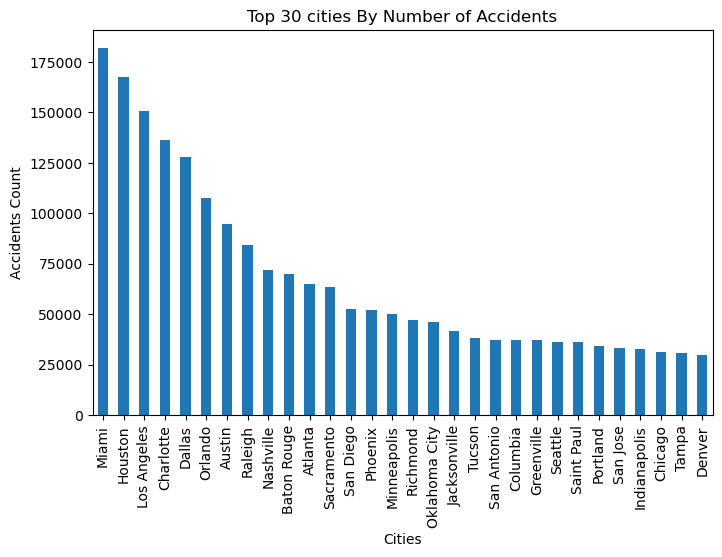

In [23]:
accidents_by_cities = us_accidents['City'].value_counts()

fig, ax = plt.subplots(figsize=(8,5))
accidents_by_cities[:30].plot(kind='bar')
ax.set(title = 'Top 30 cities By Number of Accidents',
       xlabel = 'Cities',
       ylabel = 'Accidents Count')
plt.show()

In the plot above we cann see 30 cities that have the higher number of accidents. Although we shouldn't make any definite conclusions about this distribution without comparing it to the cities' areas or population, we can still see that there are some cities that are much more problematic than others: e.g. Miami has the highest number of accidents, and it's only a 44th city in USA when it comes to population according to 2022 statistics - which is something to look into.

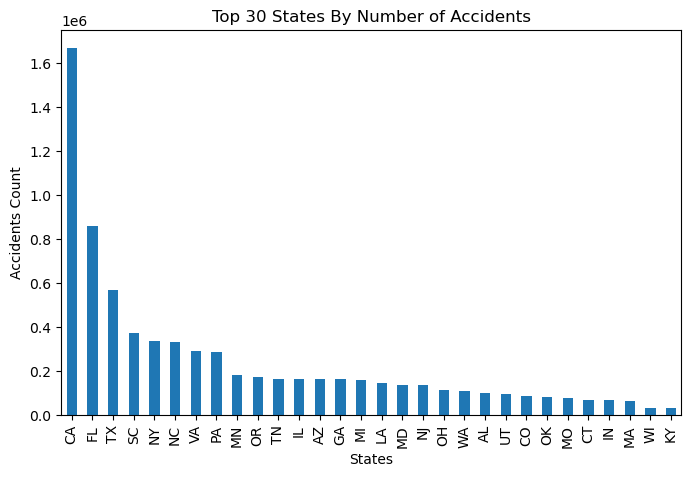

In [24]:
accidents_by_State = df['State'].value_counts()

fig, ax = plt.subplots(figsize=(8,5))
accidents_by_State[:30].plot(kind='bar')
ax.set(title = 'Top 30 States By Number of Accidents',
       xlabel = 'States',
       ylabel = 'Accidents Count')
plt.show()

In the plot above we can see the distribution of accidents in different states. There is a highest number of accidents in California, which is the most populous state and the 3rd largest in the US, but there are 2 times more accidents than in Florida (which is the 3rd most populous state, but only 22nd when it comes to area)!

# 5.Visualizations

## Explain the visualizations you've chosen. 

## Why are they right for the story you want to tell? 


### Missing Values percentage

The figure showcasing missing values percentage is crucial for understanding the data quality and completeness. By visualizing the percentage of missing values for each feature, we can assess the overall data reliability and identify areas where imputation or data collection efforts may be needed. This visualization sets the foundation for data preprocessing and ensures transparency in our analysis and a good starting point for our venture into traffic accidents in the state of California

### Weather Conditions Charts

The chosen charts, covering temperature, humidity, pressure, visibility, and wind speed, illustrate the impact of weather on traffic accidents in California. When thinking of traffic accidents weather conditions was one of the first things we could think of as potential causes and therefore it was interesting to see of there was any correlation between accident rate and bad weather. The charts are aiming towards simplifying the data as the numbers we're looking at could potentially be overwhelming or cause confusion. 

We found out, that accidents mostly occur in clear weather conditions which makes sense logically as bad weather could potentially refrain some people from driving and thus decrease the amount of overall people on the road and therefore the total amount of accidents. 

### Traffic Situation charts

The charts, which explore various traffic situations such as railway crossings, roundabouts, stops, and so on, provide valuable insights into their impact on traffic accidents in California. Initially, when considering potential accident causes, these specific traffic scenarios were obvious places for them to occur. The bar charts showcasing "True" or "False" for each respective category gives us an overview of how large the chunk of each accident is compared to the total amount of accidents, we used bar Charts for simplicitys sake.  **Junction** and **traffic signal** are the most common, appearing in respectively around 11% and 8% of all records showcasing that 1/5th of accidents in california occur at those traffic situations, giving us insight into the cause for a lot of these accidents. Now we could investigate further.

### Severity of accidents

Next we have histograms with severity of accidents in California and various histograms showcasing the severity in other US states. Here we learned that the vast majority of accidents aren't really severe, which lines up well with our previous finding of where a lot of these accidents occur (Junction and traffic signal). To further gain an understanding of the severity we made histograms of other US states to find more perspective in our own results.

### Amount of Accidents over the years

Now that our understanding of the Severity has deepened we can look into the amount of accidents categorized by severity over the years. Here we can see a decrease in accidents of severity 3 and a sharp increase of severity 2 accidents. The changes started in the year of 2018 but the most drastic changes started in the year of 2020, which interestingly enough was the year covid 19 spread dramatically throughout the world. Th color coded lines makes each severity readable with the timeframe displayed on the horisontal axis and amounts on the vertical axis

We have an overview of traffic accident places, severity and severity/amount development over the years so the next segment seems like an obvious one

### distribution of accidents

To further give any potential readers a full picture of the accidents in california its important to understand **When** the accidents occur. Thats why we've made various boxplots showcasing various timeframes such as "accidents per hour of the day" or "accidents per day of the week". With this knowledge we can see that accidents mostly occur in the rush hours (when people are going to and from work/school) and that they mostly occus in the weekdays. The simple boxplots makes it extremely easy to understand the correlation between the x and y. As we previously surmised, accidents happen in the rush hours to and from work/school which is further confirmed when looking at the bar charts displaying accidents per day of the week. 

### Miscellaneous

We got an overall decent understanding of traffic accidents in California now but our knowledge can always improve. And for that we've made some misc plots such as:

Plot showcasing accidents over a longer time period. Making Analysis easier as more data means more confidence. The lines with dots makes it straightforward to see the which amount the graph is showing at which date with the thin line making it easy to spot trends. The x axis showcasing the time period seperated by a month provides a clear reference for the amounts on the y-axis which are seperated by intervals of 25000.

Making a bar chart of the weather again made it straightforward to analyze by compacting all weather categories into one plot with accident count on the Y-axis. Sorting the weather categories by decreasing makes it easy for the reader to digest all the information, as the most vital piece of info is to the left  (which is likely also the first thing the reader will see).

The Heatmap of counties in California showcasing where the accidents occur is a nice visual representation that keeps the viewer interested and further underlines our points of accidents being a result of population density and rush hours. 

Lastly we wanted to deepen our perspective by further comparing california with other US states and in which US cities the most amount of accidents occur. The Bar charts makes it easy to distinguish the numbers for each state or city. 

